# Interactive Bath Model Analysis

This notebook provides an interactive analysis of different bosonic bath models used in quantum optics and open quantum systems. It allows comparison between different bath types and their spectral properties.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Bath Model Definitions](#definitions)
3. [Interactive Parameter Controls](#controls)
4. [Bath Comparison Analysis](#comparison)
5. [Temperature Effects](#temperature)
6. [Correlation Function Analysis](#correlation)

### Discussion: Units of Spectral Density in Different Conventions
$J(\omega)$ describes the spectral density of environmental modes at a given frequency $\omega$ and how strongly these modes couple to the system.
In the [paper](https://pubs.aip.org/aip/jcp/article/124/23/234505/930637/Two-dimensional-optical-three-pulse-photon-echo), **spectroscopic units of cm⁻¹** are used for transition frequencies ("wavenumbers"). The spectral density is defined as:
$$
J(\omega) = \alpha^2 \frac{\omega}{\omega_c} \exp\left(-\frac{\omega}{\omega_c}\right)
$$
where:
- $\alpha$ is the dimensionless coupling strength,
- $\omega_c$ is the cutoff frequency,
- $\omega$ is the frequency.

**Units:**  
- $J(\omega)$ is dimensionless in this context.


In **QuTiP**, the Ohmic spectral density is typically written as:
$$
J(\omega) = \alpha \frac{\omega^s}{\omega_c^{s-1}} \exp\left(-\frac{\omega}{\omega_c}\right)
$$
For the Ohmic case ($s = 1$):
$$
J(\omega) = \alpha \omega \exp\left(-\frac{\omega}{\omega_c}\right)
$$
where:
- $\alpha$ is the dimensionless coupling strength,
- $\omega_c$ is the cutoff frequency,
- $\omega$ is the frequency.

**Units:**  
- $J(\omega)$ now has units of frequency ($[\omega]$).


#### Physical Meaning

According to [Wikipedia](https://en.wikipedia.org/wiki/Spectral_density), the spectral density $J(\omega)$ represents the **amount of Power per unit frequency range**. ---

**References:**  
- Weiss, U. (2012). Quantum Dissipative Systems.

$$
H_{\text{SB}} = \Sigma_i F_i Aᵢ
$$

$$
[\mathbf{A}_i] = \left[\mu\right] = 1  \quad \text{(dimensionless (in the paper))}
$$

$$
[H_{\text{SB}}] = \left[J\right] = \left[eV\right]
$$

Then:
$$
[F_i] = \left[ J\right] = \left[eV\right]
$$

And:
$$
[g_x^i] = \left[ J\right] = \left[eV\right] = \left[ \omega\right] \text{(because [hbar]=1)}
$$

$$
[J_i(\omega)] = [g_x^{i\,2} \, \delta(\omega)] = \left[\omega\right] \text{(matches the Qutip definition)}
$$
But now:
$$
[J(\omega)] = [\alpha^2] ?=? \left[\omega^2\right]
$$


**Actually the coupling constant in the paper is Not dimensionless**


In [1]:
# =============================
# SETUP AND IMPORTS
# =============================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import BosonicEnvironment, OhmicEnvironment
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Import bath functions
from qspectro2d.baths. bath_fcts import *
from qspectro2d.visualization import mpl_tex_settings

# Set matplotlib backend and style
mpl.use("inline")
plt.style.use('default')

## Bath Model Definitions

We analyze three main types of bosonic baths:

1. **Paper Bath**: Exponential cutoff spectral density as used in the research paper
2. **Ohmic Bath**: Power-law spectral density with exponential cutoff  
3. **Drude-Lorentz Bath**: Lorentzian spectral density commonly used in condensed matter

Each bath is characterized by its spectral density $J(\omega)$ and Power spectrum $S(\omega)$.

In [2]:
# =============================
# BATH MODEL CONSTANTS AND PARAMETERS
# =============================

# Physical constants (normalized units)
Boltzmann = 1.0  # Boltzmann constant
hbar = 1.0       # Reduced Planck constant

# Default parameter sets for different bath types
def get_default_parameters():
    """Get default parameter sets for all bath types"""
    
    # Base parameters
    Temp = 1e-3      # Temperature
    alpha = 1e2       # Dimensionless coupling strength
    cutoff = 1e3     # Cutoff frequency
    
    # bath parameters
    args_ = {
        "alpha": alpha,     # dimensionless coupling strength # np.sqrt(alpha * cutoff),
        "cutoff": cutoff,  # cutoff frequency
        "s": 1.0,       # (SUB: <1/SUPER:>1 -) ohmic exponent
        "hbar": hbar,
        "Temp": Temp,
        "Boltzmann": Boltzmann,
    }
    return args_

# Get default parameters
args_ = get_default_parameters()

print("🔧 Default bath parameters loaded:")
print(f"   Temperature: {args_['Temp']:.1e}")
print(f"   Coupling α: {args_['alpha']:.1e}")
print(f"   Cutoff: {args_['cutoff']:.1e}")

🔧 Default bath parameters loaded:
   Temperature: 1.0e-03
   Coupling α: 1.0e+02
   Cutoff: 1.0e+03


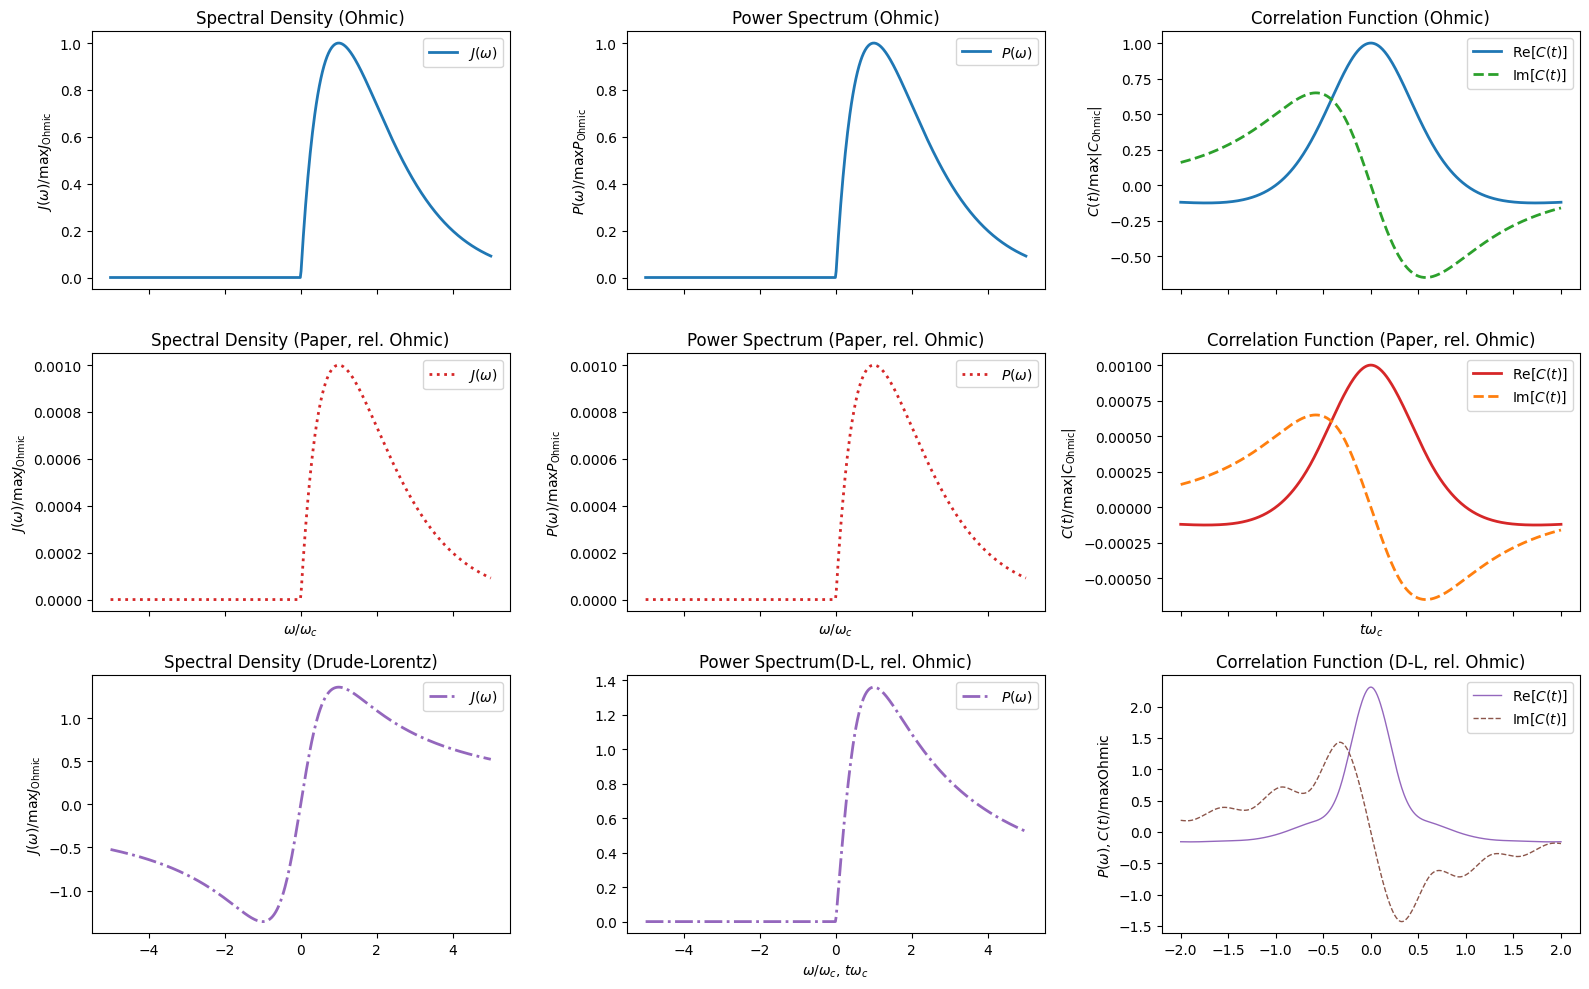

In [3]:
# SEPARATE AXIS PLOTS FOR PAPER, OHMIC, AND DRUDE-LORENTZ BATHS
# =============================
Lorentzian_env = BosonicEnvironment.from_spectral_density(
    lambda w: spectral_density_func_drude_lorentz(w, args_),
    wMax=10 * args_["cutoff"],
    T=args_["Temp"]
)

# Frequency range for each bath
omega = np.linspace(-5 * args_["cutoff"], 5 * args_["cutoff"], 500)

# Time axes for correlation functions
times = np.linspace(-2 / args_["cutoff"], 2 / args_["cutoff"], 500)

# Power spectrum and spectral density for each bath
P_vals_paper = power_spectrum_func_paper(omega, args_)
J_vals_paper = spectral_density_func_paper(omega, args_)
P_vals_drude_lorentz = Lorentzian_env.power_spectrum(omega)
J_vals_drude_lorentz = spectral_density_func_drude_lorentz(omega, args_)

bath_ohmic = OhmicEnvironment(
    T=args_["Temp"],
    wc=args_["cutoff"],
    s=args_["s"],
    alpha=args_["alpha"]
)
spec_fct_ohmic = bath_ohmic.spectral_density
P_fct_ohmic = bath_ohmic.power_spectrum

P_vals_ohmic = P_fct_ohmic(omega)
J_vals_ohmic = spec_fct_ohmic(omega)

corr_paper = BosonicEnvironment.from_power_spectrum( # TODO NOT 100% with paper -> used qutip to compute correlation function
    lambda w: power_spectrum_func_paper(w, args_),
    wMax=10 * args_["cutoff"],
    T=args_["Temp"]
).correlation_function(times)
corr_ohmic = bath_ohmic.correlation_function(times)
corr_DL = Lorentzian_env.correlation_function(times)

# Create 2x4 subplots with shared x-axes for each column
fig, axes = plt.subplots(3, 3, figsize=(16, 10), sharex='col')

# --- Ohmic Bath Subplots (first row) ---
J_max_ohmic = np.max(np.abs(J_vals_ohmic)) if np.any(J_vals_ohmic != 0) else 1
P_max_ohmic = np.max(np.abs(P_vals_ohmic)) if np.any(P_vals_ohmic != 0) else 1
C_max_ohmic = np.max(np.abs(corr_ohmic)) if np.any(corr_ohmic != 0) else 1

axes[0, 0].plot(omega / args_["cutoff"], J_vals_ohmic / J_max_ohmic, color='C0', linestyle='solid', label=r"$J(\omega)$", linewidth=2)
axes[0, 0].set_ylabel(r"$J(\omega) / \max J_\mathrm{Ohmic}$")
axes[0, 0].set_title("Spectral Density (Ohmic)")
axes[0, 0].legend()

axes[0, 1].plot(omega / args_["cutoff"], P_vals_ohmic / P_max_ohmic, color='C0', linestyle='solid', label=r"$P(\omega)$", linewidth=2)
axes[0, 1].set_ylabel(r"$P(\omega) / \max P_\mathrm{Ohmic}$")
axes[0, 1].set_title("Power Spectrum (Ohmic)")
axes[0, 1].legend()

axes[0, 2].plot(times * args_["cutoff"], np.real(corr_ohmic) / C_max_ohmic, color='C0', linestyle='solid', label=r"Re$[C(t)]$", linewidth=2)
axes[0, 2].plot(times * args_["cutoff"], np.imag(corr_ohmic) / C_max_ohmic, color='C2', linestyle='dashed', label=r"Im$[C(t)]$", linewidth=2)
axes[0, 2].set_ylabel(r"$C(t) / \max |C_\mathrm{Ohmic}|$")
axes[0, 2].set_title("Correlation Function (Ohmic)")
axes[0, 2].legend()

# --- Paper Bath Subplots (second row, normalized to Ohmic) ---
axes[1, 0].plot(omega / args_["cutoff"], J_vals_paper / J_max_ohmic, color='C3', linestyle='dotted', label=r"$J(\omega)$", linewidth=2)
axes[1, 0].set_xlabel(r"$\omega / \omega_c$")
axes[1, 0].set_ylabel(r"$J(\omega) / \max J_\mathrm{Ohmic}$")
axes[1, 0].set_title("Spectral Density (Paper, rel. Ohmic)")
axes[1, 0].legend()

axes[1, 1].plot(omega / args_["cutoff"], P_vals_paper / P_max_ohmic, color='C3', linestyle='dotted', label=r"$P(\omega)$", linewidth=2)
axes[1, 1].set_xlabel(r"$\omega / \omega_c$")
axes[1, 1].set_ylabel(r"$P(\omega) / \max P_\mathrm{Ohmic}$")
axes[1, 1].set_title("Power Spectrum (Paper, rel. Ohmic)")
axes[1, 1].legend()

axes[1, 2].plot(times * args_["cutoff"], np.real(corr_paper) / C_max_ohmic, color='C3', linestyle='solid', label=r"Re$[C(t)]$", linewidth=2)
axes[1, 2].plot(times * args_["cutoff"], np.imag(corr_paper) / C_max_ohmic, color='C1', linestyle='dashed', label=r"Im$[C(t)]$", linewidth=2)
axes[1, 2].set_xlabel(r"$t \omega_c$")
axes[1, 2].set_ylabel(r"$C(t) / \max |C_\mathrm{Ohmic}|$")
axes[1, 2].set_title("Correlation Function (Paper, rel. Ohmic)")
axes[1, 2].legend()


# --- Drude-Lorentz Bath Subplots (third row, normalized to Ohmic) ---
axes[2, 0].plot(omega / args_["cutoff"], J_vals_drude_lorentz / J_max_ohmic, color='C4', linestyle='dashdot', label=r"$J(\omega)$", linewidth=2)
axes[2, 0].set_ylabel(r"$J(\omega) / \max J_\mathrm{Ohmic}$")
axes[2, 0].set_title("Spectral Density (Drude-Lorentz)")
axes[2, 0].legend()

axes[2, 1].plot(omega / args_["cutoff"], P_vals_drude_lorentz / P_max_ohmic, color='C4', linestyle='dashdot', label=r"$P(\omega)$", linewidth=2)
axes[2, 1].set_xlabel(r"$\omega / \omega_c$, $t \omega_c$")
axes[2, 1].set_title("Power Spectrum(D-L, rel. Ohmic)")
axes[2, 1].legend()

axes[2, 2].plot(times * args_["cutoff"], np.real(corr_DL) / C_max_ohmic, color='C4', linestyle='solid', label=r"Re$[C(t)]$", linewidth=1)
axes[2, 2].plot(times * args_["cutoff"], np.imag(corr_DL) / C_max_ohmic, color='C5', linestyle='dashed', label=r"Im$[C(t)]$", linewidth=1)
axes[2, 2].set_ylabel(r"$P(\omega), C(t) / \max \mathrm{Ohmic}$")
axes[2, 2].set_title("Correlation Function (D-L, rel. Ohmic)")
axes[2, 2].legend()

plt.tight_layout()
plt.show()

## Interactive Parameter Controls

Use the controls below to explore how different parameters affect the bath properties:

In [4]:
# =============================
# INTERACTIVE BATH ANALYSIS WITH CORRELATION FUNCTIONS
# =============================
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from qutip import BosonicEnvironment, OhmicEnvironment
from IPython.display import display, clear_output

def create_interactive_controls():
    """Create interactive widgets for parameter exploration"""
    
    # Parameter sliders
    temp_slider = widgets.FloatLogSlider(
        value=1e-2,
        base=10,
        min=-4, max=2,
        step=0.1,
        description='Temperature:',
        readout_format='.2e',
        style={'description_width': 'initial'}
    )
    
    eta_slider = widgets.FloatLogSlider(
        value=1e-2,
        base=10,
        min=-4, max=0,
        step=0.1,
        description='Coupling α:',
        readout_format='.2e',
        style={'description_width': 'initial'}
    )
    
    cutoff_slider = widgets.FloatLogSlider(
        value=1e2,
        base=10,
        min=0, max=3,
        step=0.1,
        description='Cutoff ωc:',
        readout_format='.1e',
        style={'description_width': 'initial'}
    )
    
    freq_range_slider = widgets.FloatRangeSlider(
        value=[-0.5, 5],
        min=-2, max=10,
        step=0.5,
        description='Freq Range:',
        style={'description_width': 'initial'}
    )
    
    bath_selector = widgets.SelectMultiple(
        options=['Paper Bath', 'Ohmic Bath', 'Drude-Lorentz'],
        value=['Paper Bath', 'Ohmic Bath', 'Drude-Lorentz'],
        description='Bath Types:',
        style={'description_width': 'initial'}
    )
    
    return temp_slider, eta_slider, cutoff_slider, freq_range_slider, bath_selector

def interactive_comprehensive_bath_analysis(temp, alpha, cutoff, freq_range, selected_baths):
    """Interactive plotting function for comprehensive bath analysis with correlation functions"""
    clear_output(wait=True)
    
    # Update parameters
    current_args_ = {
        "alpha": alpha,
        "cutoff": cutoff,
        "Boltzmann": 1.0,  # Normalized units
        "hbar": 1.0,       # Normalized units
        "Temp": temp,
        "s": 1.0,
    }
    
    # Generate frequency data
    omega = np.linspace(freq_range[0] * cutoff, freq_range[1] * cutoff, 500)
    
    # Generate time data for correlation functions
    times = np.linspace(0, 2 / cutoff, 500)
    
    # Dictionary to store bath functions and data
    bath_data = {}
    
    # Create environments for each selected bath
    for bath_name in selected_baths:
        if bath_name == 'Paper Bath':
            # Paper Bath
            bath_data[bath_name] = {
                'J_func': spectral_density_func_paper,
                'S_func': power_spectrum_func_paper
            }
            bath_data[bath_name]['env'] = BosonicEnvironment.from_power_spectrum(
                lambda w: power_spectrum_func_paper(w, current_args_),
                wMax=10 * cutoff,
                T=temp
            )
        elif bath_name == 'Ohmic Bath':
            # Ohmic Bath
            bath_ohmic = OhmicEnvironment(
                T=temp,
                wc=cutoff,
                s=1.0,
                alpha=alpha
            )
            bath_data[bath_name] = {
                'J_func': spectral_density_func_ohmic,
                'S_func': lambda w_arr, args: np.array([bath_ohmic.power_spectrum(w) for w in w_arr]),
                'env': bath_ohmic
            }
        else:  # Drude-Lorentz
            # Drude-Lorentz Bath
            bath_data[bath_name] = {
                'J_func': spectral_density_func_drude_lorentz,
                'S_func': power_spectrum_func_drude_lorentz
            }
            bath_data[bath_name]['env'] = BosonicEnvironment.from_spectral_density(
                lambda w: spectral_density_func_drude_lorentz(w, current_args_),
                wMax=10 * cutoff,
                T=temp
            )
    
    # Calculate bath properties
    for bath_name, bath in bath_data.items():
        # Calculate spectral density
        bath['J_vals'] = np.array([bath['J_func'](w, current_args_) for w in omega])
        
        # Calculate power spectrum
        if bath_name == 'Paper Bath':
            bath['P_vals'] = bath['S_func'](omega, current_args_)
        elif bath_name == 'Ohmic Bath':
            bath['P_vals'] = np.array([bath['env'].power_spectrum(w) for w in omega])
        else:  # Drude-Lorentz
            bath['P_vals'] = bath['env'].power_spectrum(omega)
        
        # Calculate correlation function
        bath['corr'] = bath['env'].correlation_function(times)
    
    # Find maximum values for normalization (use Ohmic as reference if available)
    if 'Ohmic Bath' in bath_data:
        ref_bath = 'Ohmic Bath'
    else:
        ref_bath = list(bath_data.keys())[0]
        
    J_max_ref = np.max(np.abs(bath_data[ref_bath]['J_vals'])) if np.any(bath_data[ref_bath]['J_vals'] != 0) else 1
    P_max_ref = np.max(np.abs(bath_data[ref_bath]['P_vals'])) if np.any(bath_data[ref_bath]['P_vals'] != 0) else 1
    C_max_ref = np.max(np.abs(bath_data[ref_bath]['corr'])) if np.any(bath_data[ref_bath]['corr'] != 0) else 1
    
    # Create plot with 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharex='col')
    fig.suptitle(f'Bath Analysis: T={temp:.1e}, α={alpha:.1e}, ωc={cutoff:.1e}', 
                 fontsize=16, fontweight='bold')
    
    # Line styles and colors
    styles = {
        'Ohmic Bath': {'color': 'C0', 'linestyle': 'solid', 'linewidth': 2},
        'Paper Bath': {'color': 'C3', 'linestyle': 'dotted', 'linewidth': 2},
        'Drude-Lorentz': {'color': 'C4', 'linestyle': 'dashdot', 'linewidth': 2}
    }
    
    # Create row titles
    row_titles = list(selected_baths)
    
    # Plot baths in rows
    for i, bath_name in enumerate(selected_baths):
        if i >= 3:  # Limit to 3 rows
            break
            
        style = styles.get(bath_name, {'color': f'C{i}', 'linestyle': 'solid', 'linewidth': 2})
        
        # Compute normalized values
        J_vals = bath_data[bath_name]['J_vals'] / J_max_ref
        P_vals = bath_data[bath_name]['P_vals'] / P_max_ref
        corr = bath_data[bath_name]['corr'] / C_max_ref
        
        # Plot spectral density
        axes[i, 0].plot(
            omega / cutoff, 
            J_vals,
            label=fr"$J(\omega)$", 
            **style
        )
        axes[i, 0].set_ylabel(fr"$J(\omega) / \max J_{{\mathrm{{{ref_bath.split()[0]}}}}}$")
        axes[i, 0].set_title(f"Spectral Density ({bath_name})")
        axes[i, 0].legend()
        
        # Plot power spectrum
        axes[i, 1].plot(
            omega / cutoff, 
            P_vals, 
            label=fr"$P(\omega)$", 
            **style
        )
        axes[i, 1].set_ylabel(fr"$P(\omega) / \max P_{{\mathrm{{{ref_bath.split()[0]}}}}}$")
        axes[i, 1].set_title(f"Power Spectrum ({bath_name})")
        axes[i, 1].legend()
        
        # Plot correlation function
        axes[i, 2].plot(
            times * cutoff, 
            np.real(corr), 
            label=fr"$\mathrm{{Re}}[C(t)]$", 
            color=style['color'], 
            linestyle='solid',
            linewidth=style['linewidth']
        )
        axes[i, 2].plot(
            times * cutoff, 
            np.imag(corr), 
            label=fr"$\mathrm{{Im}}[C(t)]$", 
            color=f"C{i+2}" if i < 3 else f"C{i-3}", 
            linestyle='dashed',
            linewidth=style['linewidth']
        )
        axes[i, 2].set_ylabel(fr"$C(t) / \max |C_{{\mathrm{{{ref_bath.split()[0]}}}}}|$")
        axes[i, 2].set_title(f"Correlation Function ({bath_name})")
        axes[i, 2].legend()
    
    # Set x-axis labels for bottom row only
    for ax in axes[2, :]:
        if ax == axes[2, 0]:
            ax.set_xlabel(r"$\omega / \omega_c$")
        elif ax == axes[2, 1]:
            ax.set_xlabel(r"$\omega / \omega_c$")
        else:
            ax.set_xlabel(r"$t \omega_c$")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust for suptitle
    plt.show()
    
    print(f"🔍 Analysis complete for: {', '.join(selected_baths)}")
    print(f"   Reference bath for normalization: {ref_bath}")

# Create and display interactive controls
temp_slider, eta_slider, cutoff_slider, freq_range_slider, bath_selector = create_interactive_controls()

# Display controls
print("🎛️ Interactive Bath Analysis Controls:")
display(widgets.VBox([
    widgets.HBox([temp_slider, eta_slider]),
    widgets.HBox([cutoff_slider, freq_range_slider]),
    bath_selector
]))

# Create interactive plot
interactive_plot = widgets.interactive(
    interactive_comprehensive_bath_analysis,
    temp=temp_slider,
    alpha=eta_slider,
    cutoff=cutoff_slider,
    freq_range=freq_range_slider,
    selected_baths=bath_selector
)

display(interactive_plot)

🎛️ Interactive Bath Analysis Controls:


interactive(children=(FloatLogSlider(value=0.01, description='Temperature:', max=2.0, min=-4.0, readout_format…

## Temperature Effects Analysis

Explore how temperature affects the bath properties, particularly the Power spectrum and correlation functions:

🌡️ Analyzing temperature effects...


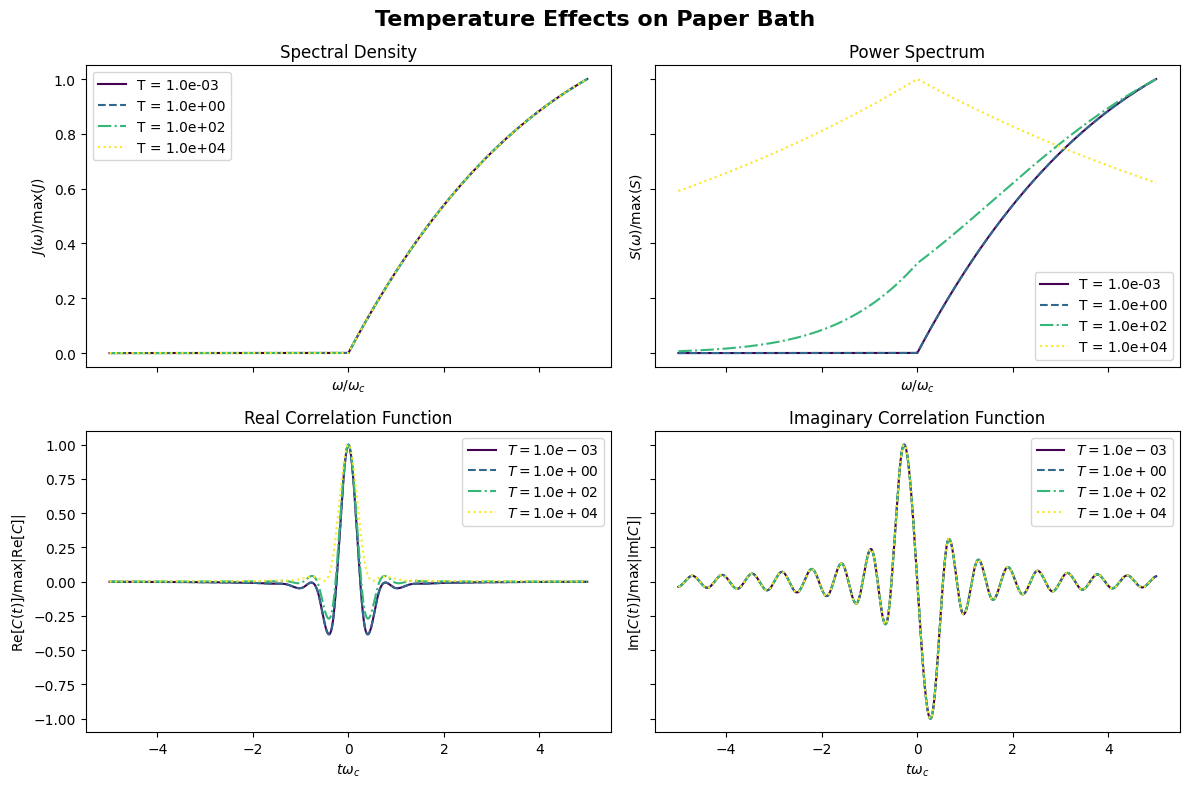

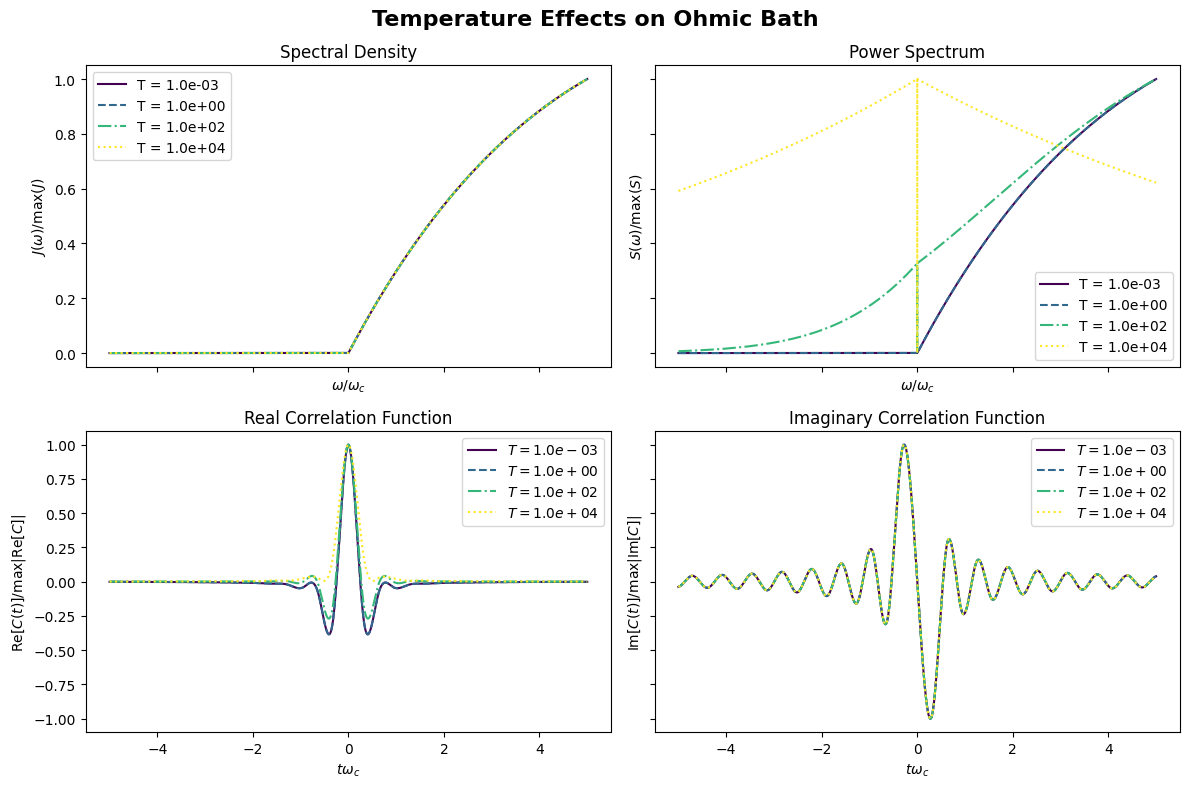

In [5]:
# =============================
# TEMPERATURE EFFECTS ANALYSIS
# =============================

def analyze_temperature_effects(bath_type='Paper Bath', temperatures=None):
    """Analyze how temperature affects bath properties"""
    
    if temperatures is None:
        temperatures = [1e-3, 1, 1e2, 1e4]
    linestyles = ['solid', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 10))]

    cutoff = 1e2
    alpha = 1e-2
    frequencies = np.linspace(-5 * cutoff, 5 * cutoff, 10001)
    times = np.linspace(-5 / cutoff, 5 / cutoff, 10001)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='row')
    fig.suptitle(f'Temperature Effects on {bath_type}', fontsize=16, fontweight='bold')
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))
    
    for i, temp in enumerate(temperatures):
        linestyle = linestyles[i % len(linestyles)] # cycle through linestyles
        color = colors[i]
        args_ = get_default_parameters()
        # Update arguments with current temperature
        args_["Temp"] = temp
        args_["Temp"] = temp
        args_["Temp"] = temp        
        if bath_type == 'Paper Bath':
            args = args_
            J_func = spectral_density_func_paper
            S_func = power_spectrum_func_paper
        elif bath_type == 'Ohmic Bath':
            args = args_
            J_func = spectral_density_func_ohmic
            S_func = power_spectrum_func_ohmic
        
        # Calculate spectral density and Power spectrum
        J_vals = np.array([J_func(w, args) for w in frequencies])
        S_vals = np.array([S_func(w, args) for w in frequencies])
        
        # Plot spectral density (should be temperature independent)
        J_max = np.max(np.abs(J_vals[J_vals > 0])) if np.any(J_vals > 0) else 1
        axes[0, 0].plot(frequencies / cutoff, 
                        J_vals / J_max, 
                        color=color, 
                        linestyle=linestyle,
                        label=f'T = {temp:.1e}')
        
        # Plot Power spectrum
        S_max = np.max(np.abs(S_vals)) if np.any(S_vals != 0) else 1
        axes[0, 1].plot(frequencies / cutoff, 
                        S_vals / S_max, 
                        color=color, 
                        linestyle=linestyle,
                        label=f'T = {temp:.1e}')
        
        # Calculate and plot correlation function using QuTiP
        try:
            if bath_type == 'Paper Bath':
                env = BosonicEnvironment.from_power_spectrum(
                    lambda w: power_spectrum_func_paper(w, args), 
                    wMax=10 * cutoff, T=temp
                )
            else:
                env = BosonicEnvironment.from_spectral_density(
                    lambda w: J_func(w, args), 
                    wMax=10 * cutoff, T=temp
                )
            
            correlation_vals = env.correlation_function(times)
    
            # Plot real part of correlation function
            C_max = np.max(np.abs(np.real(correlation_vals)))
            if C_max > 0:
                axes[1, 0].plot(
                    times * cutoff, 
                    np.real(correlation_vals) / C_max, 
                    color=color, 
                    linestyle=linestyle,
                    label=fr'$T = {temp:.1e}$'
                )

            # Plot imaginary part of correlation function
            C_imag_max = np.max(np.abs(np.imag(correlation_vals)))
            if C_imag_max > 0:
                axes[1, 1].plot(
                    times * cutoff, 
                    np.imag(correlation_vals) / C_imag_max, 
                    color=color, 
                    linestyle=linestyle,
                    label=fr'$T = {temp:.1e}$'
                )
                
        except Exception as e:
            print(f"⚠️ QuTiP error for T={temp}: {e}")
    
    # Set labels and titles
    axes[0, 0].set_xlabel(r'$ω / ω_c$')
    axes[0, 0].set_ylabel(r'$J(ω) / \max(J)$')
    axes[0, 0].set_title('Spectral Density')
    axes[0, 0].legend()
    
    axes[0, 1].set_xlabel(r'$ω / ω_c$')
    axes[0, 1].set_ylabel(r'$S(ω) / \max(S)$')
    axes[0, 1].set_title('Power Spectrum')
    axes[0, 1].legend()
    
    axes[1, 0].set_xlabel(r'$t ω_c$')
    axes[1, 0].set_ylabel(r'$\mathrm{Re}[C(t)] / \max|\mathrm{Re}[C]|$')
    axes[1, 0].set_title('Real Correlation Function')
    axes[1, 0].legend()
    
    axes[1, 1].set_xlabel(r'$t ω_c$')
    axes[1, 1].set_ylabel(r'$\mathrm{Im}[C(t)] / \max|\mathrm{Im}[C]|$')
    axes[1, 1].set_title('Imaginary Correlation Function')
    axes[1, 1].legend()

    plt.tight_layout()
    return fig, axes

# Create temperature analysis
print("🌡️ Analyzing temperature effects...")
fig_temp, axes_temp = analyze_temperature_effects('Paper Bath')
fig_temp, axes_temp = analyze_temperature_effects('Ohmic Bath')
plt.show()

### Physical Interpretation:
- **Weak coupling regime**: $α ≪ 1$ ensures validity of Born-Markov approximation
- **High temperature**: Classical limit where $S(ω) ≈ S(-ω)$
- **Low temperature**: Quantum regime with strong frequency asymmetry

In [6]:
# =============================
# EXPORT AND SAVE FUNCTIONALITY
# =============================

def save_bath_data(filename_prefix="bath_analysis", 
                  frequencies_range=(-25, 25), 
                  num_points=2000):
    """Save calculated bath data for further analysis"""
    
    cutoff = args_["cutoff"]
    frequencies = np.linspace(
        frequencies_range[0] * cutoff, 
        frequencies_range[1] * cutoff, 
        num_points
    )
    
    # Calculate data for all baths
    data_dict = {}
    
    # Paper bath
    J_paper = np.array([spectral_density_func_paper(w, args_) for w in frequencies])
    S_paper = np.array([power_spectrum_func_paper(w, args_) for w in frequencies])
    data_dict['paper'] = {
        'frequencies': frequencies,
        'J': J_paper,
        'S': S_paper,
        'args': args_
    }
    
    # Ohmic bath
    J_ohmic = np.array([spectral_density_func_ohmic(w, args_) for w in frequencies])
    S_ohmic = np.array([power_spectrum_func_ohmic(w, args_) for w in frequencies])
    data_dict['ohmic'] = {
        'frequencies': frequencies,
        'J': J_ohmic,
        'S': S_ohmic,
        'args': args_
    }
    
    # Drude-Lorentz bath
    J_dl = np.array([spectral_density_func_drude_lorentz(w, args_) for w in frequencies])
    data_dict['drude_lorentz'] = {
        'frequencies': frequencies,
        'J': J_dl,
        'args': args_
    }
    
    # Save to numpy file
    import pickle
    with open(f"{filename_prefix}.pkl", 'wb') as f:
        pickle.dump(data_dict, f)
    
    print(f"💾 Bath data saved to {filename_prefix}.pkl")
    print(f"   Contains: {list(data_dict.keys())}")
    print(f"   Frequency range: {frequencies_range}")
    print(f"   Number of points: {num_points}")
    
    return data_dict

# Save current analysis
saved_data = save_bath_data()

💾 Bath data saved to bath_analysis.pkl
   Contains: ['paper', 'ohmic', 'drude_lorentz']
   Frequency range: (-25, 25)
   Number of points: 2000


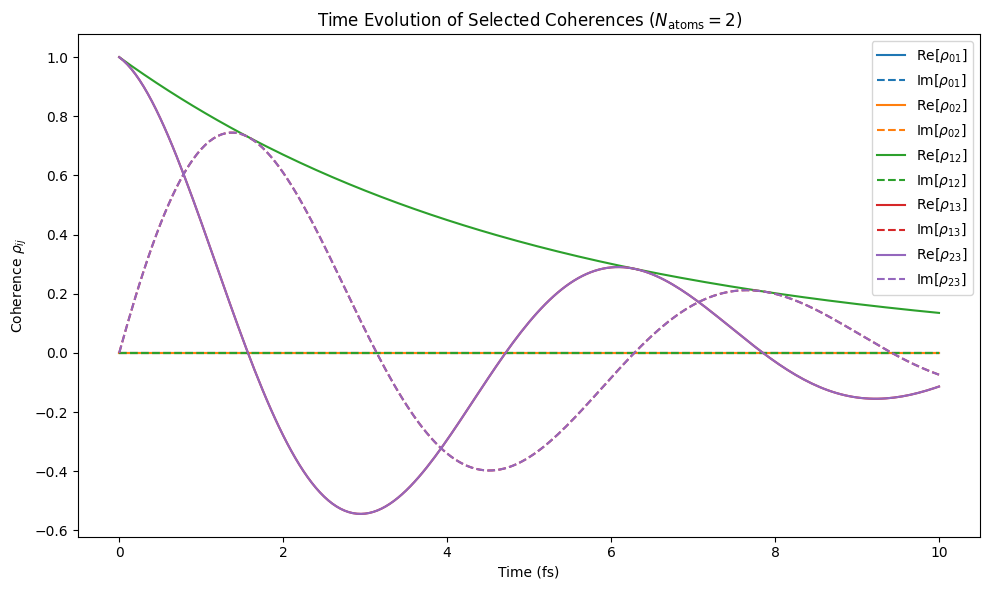

In [7]:
from qutip import basis, ket2dm, tensor, BosonicEnvironment, brmesolve
from qspectro2d.baths.bath_fcts import spectral_density_func_paper, spectral_density_func_ohmic
atom_g = basis(2, 0)  # Ground state
atom_e = basis(2, 1)  # Excited state
N_atoms = 2
Temp = 1e-1 # Temperature in Kelvin
cutoff = 100.0  # Cutoff frequency in cm^-1
alpha = 1  # Coupling strength 
Boltzmann = 1.0  # Boltzmann constant in cm^-1/K
hbar = 1.0  # Reduced Planck's constant in cm^-1*s

args_ = {
    "alpha":  alpha,
    "cutoff": cutoff,
    "Boltzmann": Boltzmann,
    "hbar": hbar,
    "Temp": Temp,
}
# Ohmic bath parameters
c = {
    "alpha": alpha,
    "cutoff": cutoff,
    "s": 1.0,
    "Boltzmann": Boltzmann,
    "Temp": Temp,
}

env = BosonicEnvironment.from_spectral_density(
    lambda w: spectral_density_func_ohmic(w, args_),
    wMax=10 * cutoff,
    T=Temp,
)
a_ops_list = []  # List to hold operators for each atom
if N_atoms == 1:
    Deph_op = (atom_e * atom_e.dag())  # Dephasing operator
    a_ops_list = [
        [Deph_op, env.power_spectrum],
    ]  # TODO THIS WAS NOT IN THE PAPER!!!!

elif N_atoms == 2:
    a_ops_list = [
        [
            ket2dm(tensor(atom_e, atom_g)),  # atom A
            env.power_spectrum,
        ],  # atom A with ohmic_spectrum
        [
            ket2dm(tensor(atom_g, atom_e)),  # atom B
            env.power_spectrum,
        ],  # atom B with ohmic_spectrum
        [
            ket2dm(tensor(atom_e, atom_e)),  # double excited state
            lambda w: env.power_spectrum(2 * w),
        ],  # double excited state with 2 * ohmic_spectrum
    ]
else:
    raise ValueError("Only N_atoms=1 or 2 are supported.")
a_ops_list
times = np.linspace(0, 10, 201)  # Time array from 0 to 100 fs
if N_atoms == 1:
    H0 = ket2dm(atom_e)  # Single atom Hamiltonian
    psi0 = atom_e+atom_g  # Initial state: atom in excited state
else:
    H0 = 2 * ket2dm(tensor(atom_e, atom_e)) + 1 * ket2dm(tensor(atom_g, atom_e)) + 1 * ket2dm(tensor(atom_e, atom_g))  # Both atoms in excited state
    psi0 = tensor(atom_e, atom_e)+tensor(atom_e, atom_g)+tensor(atom_g, atom_e)  # Initial state: both atoms in excited state
result = brmesolve(H0, psi0, times, a_ops_list)
# =============================
# VISUALIZE BRMESOLVE COHERENCES
# =============================

# Extract coherences (off-diagonal elements) for each basis state from result.states
coherences = [state.full()[0, 1] for state in result.states]  # |0><1| element for each time step
coherences = np.array(coherences)  # shape: (len(times),)

plt.figure(figsize=(10, 6))

if N_atoms == 1:
    # For a single atom, plot the coherence between |g> and |e>
    plt.plot(times, np.real(coherences), label=r"$\mathrm{Re}[\rho_{01}]$", linestyle='solid', color='C0')
    plt.plot(times, np.imag(coherences), label=r"$\mathrm{Im}[\rho_{01}]$", linestyle='dashed', color='C1')
    plt.ylabel(r"Coherence $\rho_{01}$")
    plt.title(r"Time Evolution of Coherence $\rho_{01}$ ($N_\mathrm{atoms}=1$)")
else:
    # For two atoms, plot selected coherences in the 4x4 density matrix
    # |00>, |01>, |10>, |11> basis: indices 0,1,2,3
    coh_01 = np.array([state.full()[0, 1] for state in result.states])  # |00><01|
    coh_02 = np.array([state.full()[0, 2] for state in result.states])  # |00><10|
    coh_12 = np.array([state.full()[1, 2] for state in result.states])  # |01><10|
    coh_13 = np.array([state.full()[1, 3] for state in result.states])  # |01><11|
    coh_23 = np.array([state.full()[2, 3] for state in result.states])  # |10><11|

    plt.plot(times, np.real(coh_01), label=r"$\mathrm{Re}[\rho_{01}]$", linestyle='solid', color='C0')
    plt.plot(times, np.imag(coh_01), label=r"$\mathrm{Im}[\rho_{01}]$", linestyle='dashed', color='C0')
    plt.plot(times, np.real(coh_02), label=r"$\mathrm{Re}[\rho_{02}]$", linestyle='solid', color='C1')
    plt.plot(times, np.imag(coh_02), label=r"$\mathrm{Im}[\rho_{02}]$", linestyle='dashed', color='C1')
    plt.plot(times, np.real(coh_12), label=r"$\mathrm{Re}[\rho_{12}]$", linestyle='solid', color='C2')
    plt.plot(times, np.imag(coh_12), label=r"$\mathrm{Im}[\rho_{12}]$", linestyle='dashed', color='C2')
    plt.plot(times, np.real(coh_13), label=r"$\mathrm{Re}[\rho_{13}]$", linestyle='solid', color='C3')
    plt.plot(times, np.imag(coh_13), label=r"$\mathrm{Im}[\rho_{13}]$", linestyle='dashed', color='C3')
    plt.plot(times, np.real(coh_23), label=r"$\mathrm{Re}[\rho_{23}]$", linestyle='solid', color='C4')
    plt.plot(times, np.imag(coh_23), label=r"$\mathrm{Im}[\rho_{23}]$", linestyle='dashed', color='C4')
    plt.ylabel(r"Coherence $\rho_{ij}$")
    plt.title(r"Time Evolution of Selected Coherences ($N_\mathrm{atoms}=2$)")

plt.xlabel(r"Time (fs)")
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()
